# Training curve of the LGBM model

In this notebook, we analyze the impact of the training set size on the training and test set performance of our best algorithm implemented using LightGBM (with tuned hyperparameters).

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Input data parsing

In [2]:
trainData = pd.read_csv("trainingData.csv")
testData = pd.read_csv("testData.csv")
resultsDF = pd.DataFrame(columns=["Fraction", "Metric", "Train", "Test"])

## Pipeline definition

In [3]:
pipeline = Pipeline(steps=[
    ("transformer", ColumnTransformer([("selectFeatures", "passthrough", [
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone",
        "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
    ])], remainder="drop")),
    ("regressor", LGBMRegressor(
        class_weight=None, colsample_bytree=0.75, learning_rate=0.1,
        min_child_samples=100, n_estimators=300, num_leaves=127,
        subsample=1, random_state=42, n_jobs=-1
    ))
])

## Folding

To analyze the impact of the training set size on the training and test set performance of the algorithm, we first split our training dataset in 10 non-overlapping folds; this is achieved by assigning each training record to a random number between 0 and 9. The (approximately equal) number of records assigned to each fold is reported as the output of this cell.

In [4]:
numFolds = 10
np.random.seed(42)
trainData["Fold"] = np.random.randint(numFolds, size=trainData.shape[0])
trainData["Fold"].value_counts().sort_index()

0    229490
1    230717
2    230287
3    230087
4    229904
5    230187
6    230415
7    229535
8    229892
9    229842
Name: Fold, dtype: int64

## Performance measurements

After folding, here we train 10 models, using at each iteration $i$ the first $i$ training folds as input. Once a model is trained, we use it to transform both the training sample and the full test set to compute the metrics of interest, which are also reported as output.

In [5]:
for i in range(numFolds):
    # Create the train sample by selecting the first i folds
    trainSample = trainData[trainData["Fold"] <= i].drop("Fold", axis=1)
    
    # Fit the pipeline on the train sample
    model = pipeline.fit(trainSample, trainSample["NumBikesDiff+1"])
    
    # Evaluate on the training and test sets
    trainRMSE = mean_squared_error(trainSample["NumBikes+1"], trainSample["NumBikes"] + model.predict(trainSample), squared=False)
    trainR2 = r2_score(trainSample["NumBikes+1"], trainSample["NumBikes"] + model.predict(trainSample))
    testRMSE = mean_squared_error(testData["NumBikes+1"], testData["NumBikes"] + model.predict(testData), squared=False)
    testR2 = r2_score(testData["NumBikes+1"], testData["NumBikes"] + model.predict(testData))
    resultsDF = resultsDF.append([
        {"Fraction": (i + 1) / numFolds, "Metric": "RMSE", "Train": trainRMSE, "Test": testRMSE},
        {"Fraction": (i + 1) / numFolds, "Metric": "R2", "Train": trainR2, "Test": testR2}
    ], ignore_index=True)
    
    print(f"Completed iteration #{i + 1} (RMSE train: {trainRMSE}, R2 train: {trainR2}, RMSE test: {testRMSE}, R2 test: {testR2}).")

Completed iteration #1 (RMSE train: 1.350196551224853, R2 train: 0.9658307167013905, RMSE test: 1.4185547981658453, R2 test: 0.9674739858312656).
Completed iteration #2 (RMSE train: 1.3857750477653568, R2 train: 0.9640601366190947, RMSE test: 1.4124600775821379, R2 test: 0.967752876872689).
Completed iteration #3 (RMSE train: 1.3962942032885124, R2 train: 0.9635248239105602, RMSE test: 1.4108759823249017, R2 test: 0.9678251675812347).
Completed iteration #4 (RMSE train: 1.4024996367573621, R2 train: 0.9631822218057913, RMSE test: 1.4095293216707072, R2 test: 0.967886559090007).
Completed iteration #5 (RMSE train: 1.4074323298061142, R2 train: 0.962934620959835, RMSE test: 1.408875381643385, R2 test: 0.9679163497338051).
Completed iteration #6 (RMSE train: 1.4100824336706823, R2 train: 0.962775770830179, RMSE test: 1.408388836014747, R2 test: 0.9679385056527166).
Completed iteration #7 (RMSE train: 1.4144211363193877, R2 train: 0.9625676972306522, RMSE test: 1.4079834653638454, R2 test:

Results are visualized in the following charts. We note how the training set metrics get worse (increased RMSE, decreased R2) for increasing training set size, while the test set metrics improve. Indeed, when we use a smaller training set, the model is able to better fit the fewer training records; however, the resulting model does not generalize properly on the test sets' unobserved records. Increasing the training size leads to decreased training set performance (it is harder to perfectly fit more data), but increased test set performance as the model is more robust.

With respect to the GBT case, the error achieved by the LGBM models is lower for most training set sizes. Also, here the test set metrics are  higher than the training set ones only after a certain threshold, characterized by a training set sample between 50% and 60% of the total size.

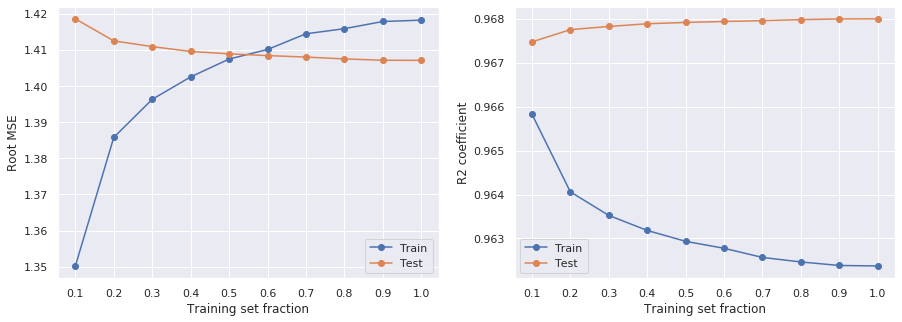

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
resultsDF[resultsDF["Metric"] == "RMSE"].plot(x="Fraction", y=["Train", "Test"], ax=ax[0], marker="o")
resultsDF[resultsDF["Metric"] == "R2"].plot(x="Fraction", y=["Train", "Test"], ax=ax[1], marker="o")
ax[0].set_xticks([(i + 1) / numFolds for i in range(numFolds)])
ax[1].set_xticks([(i + 1) / numFolds for i in range(numFolds)])
ax[0].set_xlabel("Training set fraction")
ax[1].set_xlabel("Training set fraction")
ax[0].set_ylabel("Root MSE")
ax[1].set_ylabel("R2 coefficient");